In [1]:
#generals

import numpy as np
import pandas as pd
import nltk
import csv

#preprocessing

import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

#training and validation

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

#graphs

import matplotlib.pyplot as plt
import seaborn as sns

##  <center>Data Exploration</center>

In [2]:
#Reading databases 

dev = pd.read_csv('development.csv')
eval = pd.read_csv('evaluation.csv')

In [3]:
#Development dataset description

dev.describe(include='all')

,text,class
count,28754,28754
unique,28754,2
top,Ci siamo stati per una notte ed è stato eccell...,pos
freq,1,19532


In [4]:
#Control on possible presence of null elements

dev.isnull().sum()

text     0
class    0
dtype: int64

In [5]:
#Evaluation dataset description

eval.describe(include='all')

,text
count,12323
unique,12323
top,"Prenotato per lavoro a scatola chiusa, solo pe..."
freq,1


In [6]:
#Control on possible presence of null elements

eval.isnull().sum()

text    0
dtype: int64

Each dataset doesn't contain null elements

In [7]:
#Selecting columns in each database

X = dev['text'] 
y = dev['class']
Z = eval['text']

In [8]:
#First look at class distribution 

print(y.value_counts())

pos    19532
neg     9222
Name: class, dtype: int64


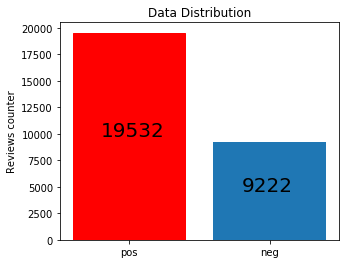

In [9]:
#Data distribution plot

def plot_graph(data):
    pos = data.loc[data['class'] == 'pos']
    neg = data.loc[data['class'] == 'neg']
    length = ["pos","neg"]
    height = [len(pos),len(neg)]
    
    fig, ax = plt.subplots(figsize=(5,4))
    barlist= ax.bar(length,height)
    barlist[0].set_color('r')
    
    for i, v in enumerate(height):
        ax.text(i-0.2,
              v-(v/2),
              height[i], 
              fontsize=20)
    plt.title("Data Distribution")
    plt.ylabel("Reviews counter")
    plt.show()

plot_graph(dev)

In [10]:
#Wordcloud function

def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 50, 
        scale = 2,
        random_state = 20, 
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15,8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
       
    plt.imshow(wordcloud)
    plt.show()

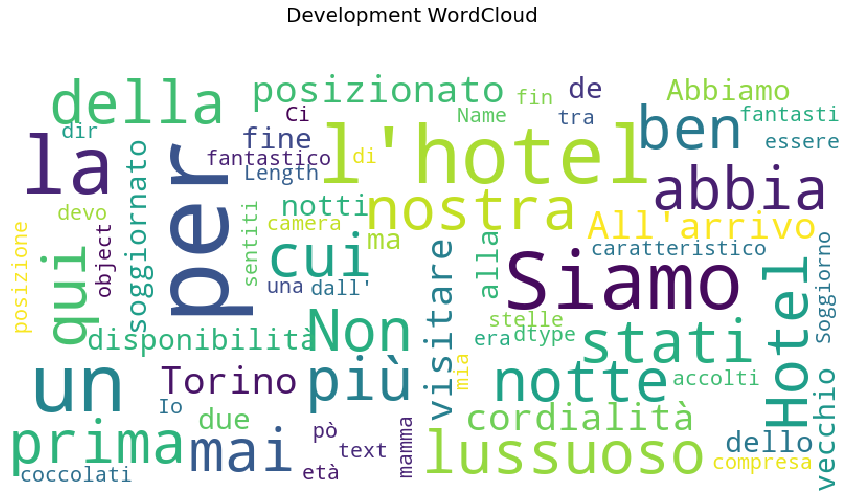

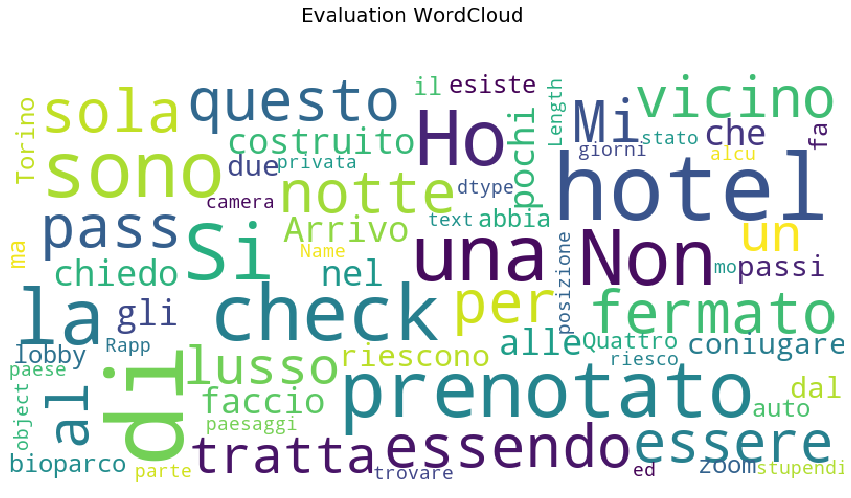

In [11]:
#First look at initial WordCloud for each dataset

show_wordcloud(X, "Development WordCloud")
show_wordcloud(Z,"Evaluation WordCloud")

## <center>Preprocessing</center>

In [12]:
#Replacing non-alphanumeric elements and moving all words to lower case

REPLACE_NO_SPACE = re.compile("[.;:!\?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(')|(\n)|(\-)|(\/)")

def preprocess_reviews(data):
    data = [REPLACE_NO_SPACE.sub("", line.lower()) for line in data]
    data = [REPLACE_WITH_SPACE.sub(" ", line) for line in data]
    return data

reviews_dev_clean = preprocess_reviews(X) 
reviews_eval_clean = preprocess_reviews(Z)

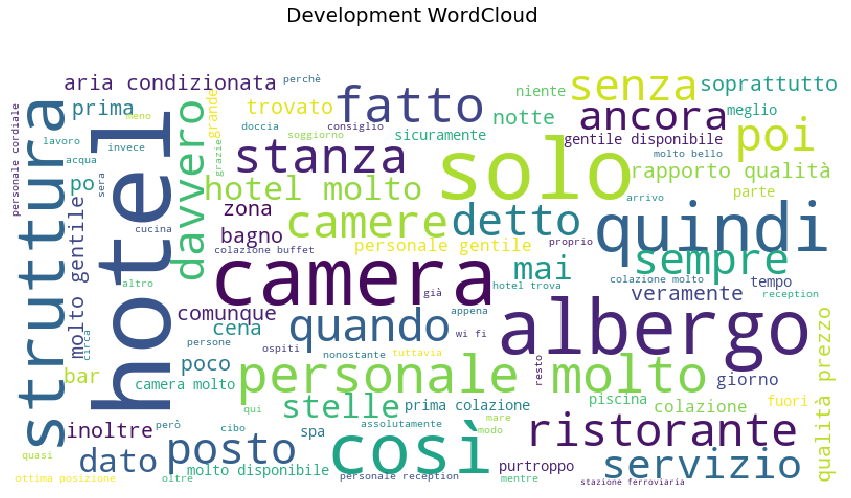

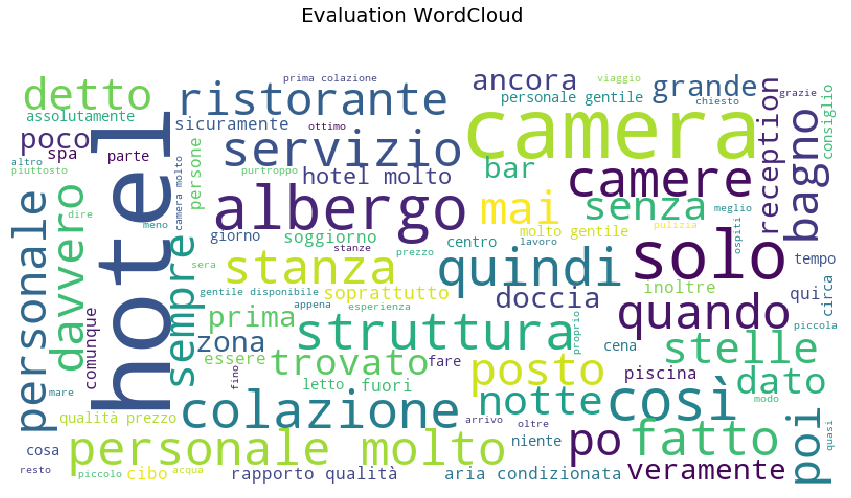

In [43]:
#Removing italian stopwords

italian_stop_words = stopwords.words('italian')+["minuti","piedi","credo","città","napoli","stato","stati","stata","dopo","san","marco","venezia","milano","visto","forse"]
def remove_stop_words(data):
    removed_stop_words = []
    for review in data:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in italian_stop_words])
        )
    return removed_stop_words

dev_no_stop_words = remove_stop_words(reviews_dev_clean)
eval_no_stop_words = remove_stop_words(reviews_eval_clean)

#WordCloud look at databases after stopwords removal

show_wordcloud(dev_no_stop_words, "Development WordCloud")
show_wordcloud(eval_no_stop_words,"Evaluation WordCloud")

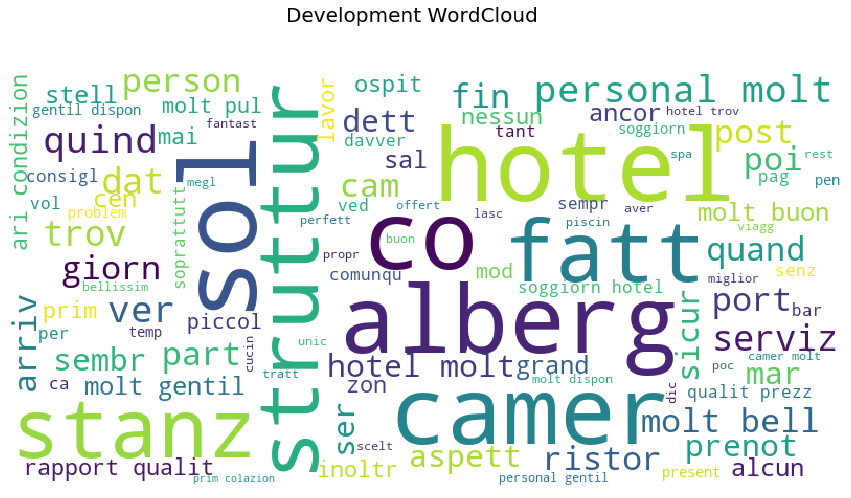

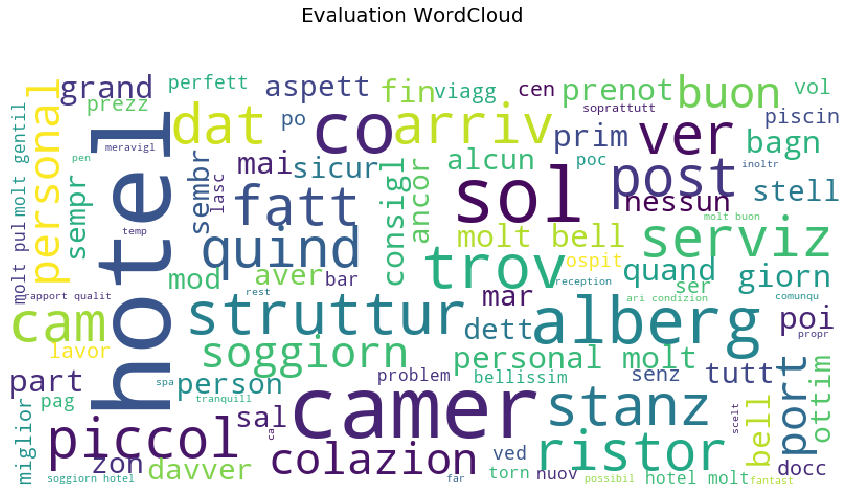

In [44]:
#Stemming the remaining words

def get_stemmed_text(data):
    stemmer = SnowballStemmer("italian")
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in data]

dev_stemmed_reviews = get_stemmed_text(dev_no_stop_words)
eval_stemmed_reviews = get_stemmed_text(eval_no_stop_words)

#WordCloud look at databases after stemming

show_wordcloud(dev_stemmed_reviews, "Development WordCloud")
show_wordcloud(eval_stemmed_reviews,"Evaluation WordCloud")

## <center>Algorithm, Tuning and Validation </center>

In [68]:
#Term frequency inverse document frequency (tf-idf)

italian_stop_words = stopwords.words('italian')
vectorizer = TfidfVectorizer(ngram_range=(1, 2),stop_words=italian_stop_words)
vectorizer.fit(dev_stemmed_reviews)
X_dev= vectorizer.transform(dev_stemmed_reviews)
X_eval = vectorizer.transform(eval_stemmed_reviews)

X_train, X_test, y_train, y_test = train_test_split(
    X_dev, y, train_size = 0.75
)

In [73]:
#Use of DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print ("F1 score with Decision Tree Classifier:  ")
print(f1_score(y_test,clf.predict(X_test), average='weighted'))

F1 score with Decision Tree Classifier:  
0.8479558876643927


In [74]:
#Use of KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print ("F1 score with K-Nearest Neighbors Classifier:  ")
print(f1_score(y_test,knn.predict(X_test), average='weighted'))

F1 score with K-Nearest Neighbors Classifier:  
0.8695802802906477


In [69]:
#Use of Linear Support Vector Machine

print ("F1 score with Linear Support Vector Classification:  ")

#Selecting the most accurate regularization parameter c

for c in [0.25,0.5,0.75,1]:
    lr = LinearSVC(C=c)
    lr.fit(X_train, y_train)
    print ("F1 score for C = %s: %s" 
           % (c, f1_score(y_test,lr.predict(X_test), average='weighted')))

F1 score with Linear Support Vector Classification:  
F1 score for C = 0.25: 0.961215994268547
F1 score for C = 0.5: 0.9651992927745601
F1 score for C = 0.75: 0.9663344835651804
F1 score for C = 1: 0.9664720535328578


In [70]:
#Final prediction   

final = LinearSVC(C=1)
final.fit(X_dev, y)
print(final.predict(X_eval))

['pos' 'neg' 'pos' ... 'neg' 'neg' 'pos']


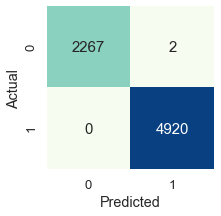

In [72]:
#Confusion matrix

conf_mat = confusion_matrix(y_test, final.predict(X_test))
conf_mat_df = pd.DataFrame(conf_mat)
conf_mat_df.index.name = 'Actual'
conf_mat_df.columns.name = 'Predicted'
plt.figure(figsize = (3,3))
sns.set(font_scale=1.2) 
sns.heatmap(conf_mat_df, annot=True, cmap='GnBu', 
            annot_kws={"size": 15}, fmt='g', cbar=False)
plt.show()

In [29]:
#Creating Ids for final csv

dataset ={}
id=0
for el in Z:
    dataset[id]=el
    id+=1

#Print the result in final csv

def dump_to_file(filename, assignments, dataset):
    with open(filename, mode="w", newline="") as csvfile:
        
        # Headers
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for ids, sentiment in zip(dataset.keys(), assignments):
            writer.writerow({'Id': str(ids), 'Predicted': str(sentiment)})
            
dump_to_file("result.csv",final.predict(X_eval),dataset )